## Trackball Analysis
*Nhat Le, May 2018*

This is a file for analysis of the left/right trackball behavior and imaging data

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import pandas as pd
import bebi103

import holoviews as hv
import bokeh.io
import bokeh.plotting


%matplotlib inline
bokeh.io.output_notebook()
hv.extension('bokeh')

ModuleNotFoundError: No module named 'pymc3'

In [2]:
# Load the data from the mat files
rawc_data = scipy.io.loadmat('raw_c.mat', squeeze_me=True)['raw_c']
rawi_data = scipy.io.loadmat('raw_i.mat', squeeze_me=True)['raw_i']
mean_velc_data = scipy.io.loadmat('mean_vel_c.mat', squeeze_me=True)['mean_vel_c']
mean_veli_data = scipy.io.loadmat('mean_vel_i.mat', squeeze_me=True)['mean_vel_i']
mvmt_startc_data = scipy.io.loadmat('mvmt_start_c.mat', squeeze_me=True)['mvmt_start_c']
mvmt_starti_data = scipy.io.loadmat('mvmt_start_i.mat', squeeze_me=True)['mvmt_start_i']
rtc_data = scipy.io.loadmat('rt_c.mat', squeeze_me=True)['rt_c']
rti_data = scipy.io.loadmat('rt_i.mat', squeeze_me=True)['rt_i']
trial_orderc_data = scipy.io.loadmat('trial_order_c.mat', squeeze_me=True)['trial_order_c']
trial_orderi_data = scipy.io.loadmat('trial_order_i.mat', squeeze_me=True)['trial_order_i']


ref_table = scipy.io.loadmat('ref_table.mat')['ref_table']
ref_frame = pd.DataFrame(ref_table, columns=['cellID', 'session', 'id_sess', 'SC', 'modulated', 'side'])

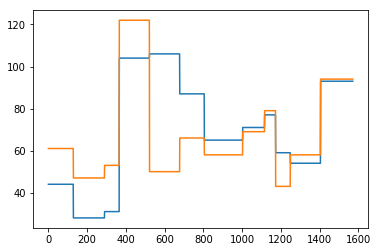

In [3]:
def get_ntrials(data):
    '''Given a raw data struct, return an array of the number 
    of trials that each cell was recorded'''
    ntrials = []
    for i in range(len(data)):
        ntrials.append(len(data[i]))
    return ntrials

ntrialsC = get_ntrials(mean_velc_data)
ntrialsI = get_ntrials(mean_veli_data)

# Maximum number of trials for each cell
ntrials_max = np.max(ntrialsC + ntrialsI)

# Number of cells
ncells = len(ntrialsC)

plt.plot(ntrialsC)
plt.plot(ntrialsI)

### Tidy data
Make a tidy data frame that contains all the information

In [4]:
def make_tidy_frame(raw_struct, contra, varname):
    '''Inputs: raw_struct, the raw data array
    contra: 1 if contra, 0 if ipsi
    ncells: number of cells
    ntrials_max: max number of trials
    Returns a tidy data frame with columns: cells, trials, varname and contra'''
    # Gather relevant parameters
    ntrials = get_ntrials(raw_struct)
    ntrials_max = max(ntrials)
    ncells = len(ntrials)
    
    # Make an array with first column being number of cells,
    # Each row is a nan-padded array representing the value of the parameter
    # of each cell
    cell_arr = np.empty((ncells, ntrials_max + 1))
    cell_arr[:] = np.nan

    for i in range(ncells):
        cell_arr[i, 1:ntrials[i] + 1] = raw_struct[i]
        cell_arr[i, 0] = i
        
    # Make the tidy frame
    cell_frame = pd.DataFrame(cell_arr)
    cell_frame = pd.melt(cell_frame, id_vars=[0], var_name='trial', value_name=varname)
    cell_frame.columns = ['cellID', 'trial', varname]
    cell_frame = cell_frame.dropna()
    cell_frame['contra'] = contra
    cell_frame.trial = cell_frame.trial - 1
    
    return cell_frame

In [5]:
mean_velC_fr = make_tidy_frame(mean_velc_data, 1, 'mean_vel')
mean_velI_fr = make_tidy_frame(mean_veli_data, 0, 'mean_vel')

mvmt_startC_fr = make_tidy_frame(mvmt_startc_data, 1, 'mvmt_start')
mvmt_startI_fr = make_tidy_frame(mvmt_starti_data, 0, 'mvmt_start')

rtC_fr = make_tidy_frame(rtc_data, 1, 'rt')
rtI_fr = make_tidy_frame(rti_data, 0, 'rt')

trial_orderC_fr = make_tidy_frame(trial_orderc_data, 1, 'trial_order')
trial_orderI_fr = make_tidy_frame(trial_orderi_data, 0, 'trial_order')

In [6]:
# Merge all data frames
Cframe = pd.merge(rtC_fr, mvmt_startC_fr, on=['cellID', 'trial', 'contra'])
Cframe = pd.merge(Cframe, mean_velC_fr, on=['cellID', 'trial', 'contra'])
Cframe = pd.merge(Cframe, trial_orderC_fr, on=['cellID', 'trial', 'contra'])

Iframe = pd.merge(rtI_fr, mvmt_startI_fr, on=['cellID', 'trial', 'contra'])
Iframe = pd.merge(Iframe, mean_velI_fr, on=['cellID', 'trial', 'contra'])
Iframe = pd.merge(Iframe, trial_orderI_fr, on=['cellID', 'trial', 'contra'])

# Now merge all into a master frame
CIframe = pd.concat([Cframe, Iframe])
all_frame = CIframe.merge(ref_frame, on='cellID')

In [7]:
# Just a check that everything is consistent
print('contra frames shapes')
print(trial_orderC_fr.shape)
print(mean_velC_fr.shape)
print(mvmt_startC_fr.shape)
print(rtC_fr.shape)
print(Cframe.shape)

print('\nipsi frames shapes')
print(trial_orderI_fr.shape)
print(mean_velI_fr.shape)
print(mvmt_startI_fr.shape)
print(rtI_fr.shape)
print(Iframe.shape)

print('\nall frames shapes')
print(all_frame.shape)

contra frames shapes
(110070, 4)
(110070, 4)
(110070, 4)
(110070, 4)
(110070, 7)

ipsi frames shapes
(106476, 4)
(106476, 4)
(106476, 4)
(106476, 4)
(106476, 7)

all frames shapes
(216441, 12)


## Data analysis

In [8]:
cell0 = all_frame[all_frame.cellID == 1]

(array([29., 14., 20., 22.,  6., 11.,  1.,  1.,  0.,  1.]),
 array([0.01 , 0.063, 0.116, 0.169, 0.222, 0.275, 0.328, 0.381, 0.434,
        0.487, 0.54 ]),
 <a list of 10 Patch objects>)

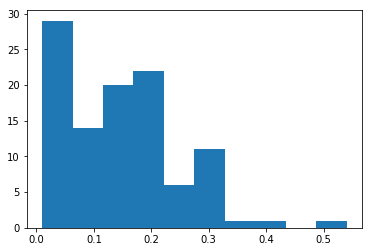

In [9]:
plt.hist(cell0.mvmt_start)

(array([34., 33., 13., 12.,  4.,  2.,  1.,  1.,  0.,  5.]),
 array([ 13.11862267,  43.40539407,  73.69216547, 103.97893687,
        134.26570827, 164.55247967, 194.83925106, 225.12602246,
        255.41279386, 285.69956526, 315.98633666]),
 <a list of 10 Patch objects>)

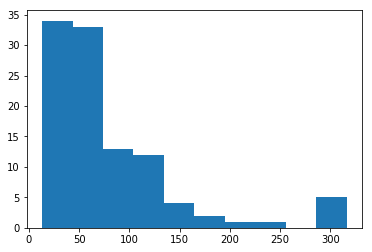

In [10]:
plt.hist(cell0.mean_vel)

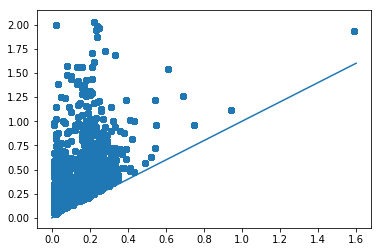

In [11]:
plt.scatter(all_frame.mvmt_start, all_frame.rt)
plt.plot([0, 1.6], [0, 1.6])

In [22]:
all_frame

,cellID,trial,rt,contra,mvmt_start,mean_vel,trial_order,session,id_sess,SC,modulated,side
0,1.0,0,0.148777,1,0.04,145.039121,85.0,1.0,1.0,0.0,0.0,NaN
1,1.0,1,0.186165,1,0.06,132.692308,101.0,1.0,1.0,0.0,0.0,NaN
2,1.0,2,0.238421,1,0.06,97.517727,102.0,1.0,1.0,0.0,0.0,NaN
3,1.0,3,0.268615,1,0.08,95.934126,61.0,1.0,1.0,0.0,0.0,NaN
4,1.0,4,0.271946,1,0.03,66.750000,19.0,1.0,1.0,0.0,0.0,NaN
5,1.0,5,0.331033,1,0.04,53.046637,79.0,1.0,1.0,0.0,0.0,NaN
6,1.0,6,0.390829,1,0.28,189.466093,137.0,1.0,1.0,0.0,0.0,NaN
7,1.0,7,0.391374,1,0.26,132.290122,109.0,1.0,1.0,0.0,0.0,NaN
8,1.0,8,0.401571,1,0.04,44.785722,34.0,1.0,1.0,0.0,0.0,NaN
9,1.0,9,0.420878,1,0.28,139.286105,45.0,1.0,1.0,0.0,0.0,NaN


In [35]:
all_frame.cellID.isin([1.0])

0          True
1          True
2          True
3          True
4          True
5          True
6          True
7          True
8          True
9          True
10         True
11         True
12         True
13         True
14         True
15         True
16         True
17         True
18         True
19         True
20         True
21         True
22         True
23         True
24         True
25         True
26         True
27         True
28         True
29         True
          ...  
216411    False
216412    False
216413    False
216414    False
216415    False
216416    False
216417    False
216418    False
216419    False
216420    False
216421    False
216422    False
216423    False
216424    False
216425    False
216426    False
216427    False
216428    False
216429    False
216430    False
216431    False
216432    False
216433    False
216434    False
216435    False
216436    False
216437    False
216438    False
216439    False
216440    False
Name: cellID, Length: 21

In [38]:
cells = all_frame[all_frame.cellID.isin([1.0, 200.0, 500.0])]

In [47]:
# Specify styles
%opts Scatter [show_grid=True, width=200, height=160] (color='#1f77b4', size=5)


scatter = hv.Scatter(cells, kdims=['mvmt_start'], vdims=['rt', 'cellID'])

gb = scatter.groupby('cellID')
#scatter.opts(style=style_opts, plot=plot_opts)
overlay = gb.overlay()
gb

:HoloMap   [cellID]
   :Scatter   [mvmt_start]   (rt,cellID)

In [48]:
kdims = ['mvmt_start', 'rt', 'mean_vel']
vdims = ['cellID']

data = hv.Dataset(cells, kdims=kdims, vdims=vdims)

gb = data.groupby('cellID', container_type=hv.NdOverlay)
hv.operation.gridmatrix(gb, diagonal_type=hv.Scatter)

:GridMatrix   [X,Y]
   :NdOverlay   [cellID]
      :Scatter   [rt]   (rt)

(array([19658.,  9749.,  3777.,  7832.,  2695.,  4305.,  5457.,  4110.,
        13546., 10117., 28187., 18173., 30629., 18484.,  6989., 14299.,
         3885.,  5585.,  2239.,  1479.,  1427.,   396.,   728.,   232.,
          436.,   526.,   317.,     0.,     0.,     0.,   156.,     0.,
          113.,   284.,   113.,     0.,     0.,   161.,     0.,     0.,
            0.,     0.,     0.,    57.,     0.,     0.,   167.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,    76.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,    57.]),
 array([0.01  , 0.0258, 0.0416, 0.0574, 0.0732, 0.089 , 0.1048, 0.1206,
        0.1364, 0.1522

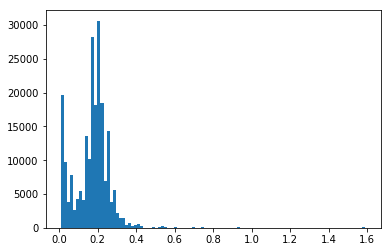

In [39]:
plt.hist(all_frame.mvmt_start, bins=100)

In [11]:
np.min(trial_orderi[0])

NameError: name 'trial_orderi' is not defined

In [ ]:
plt.hist(mvmt_startc[900])
# The two bumps are suggestive of two different modes of operation - 
# TODO: take a look at 
# the neural signatures of those two modes

In [ ]:
mean_velc_data[0].shape
mean_veli_data[0].shape


In [ ]:
ref_frame

In [ ]:
x = np.arange(10)
x[2:5]

In [ ]:
# Find z-score
cell_data = rawc_data[900]
#plt.plot(cell_data);

baseline_start = 5
baseline_end = 15

baseline_activity = cell_data[baseline_start:baseline_end]

# Find mean and std baseline
baseline_mean = np.mean(baseline_activity, axis=0)
baseline_sd = np.std(baseline_activity, axis=0)

# Normalize
cell_data_normed = (cell_data - baseline_mean) / baseline_sd
mean_cell_data = np.mean(cell_data_normed, axis=1)


plt.plot(cell_data_normed, 'b', alpha=0.1);
plt.plot(mean_cell_data)
plt.vlines(14.5, -10, 10, linestyles='dotted')

In [ ]:
cell_data.shape

In [ ]:
a = (cell_data - baseline_mean) / baseline_sd


In [ ]:
plt.plot(a);

In [ ]:
cell_data

In [ ]:
cell_num = 1400
mean_cell = np.mean(rawc_data[cell_num], axis=1)

plt.plot(rawc_data[cell_num], 'b', alpha=0.1);
plt.plot(mean_cell)

In [ ]:
means = np.zeros((1572, 31))

for i in range(1572):
    celldata = rawc_data[i]
    means[i,:] = np.mean(celldata, axis=1)

In [ ]:
plt.figure(figsize=(15,50))
plt.imshow(means)

In [ ]:
# Modulated cells are all SC
ref_pd.groupby('modulated')['SC'].mean()

In [ ]:
ref_pd[ref_pd.session == 1]

In [ ]:
# Group by SC
ref_pd.groupby('SC')['modulated'].mean()

In [ ]:
ref_pd.groupby('SC')['side'].mean()

## Correlation between cell activity and mean velocity

In [ ]:
# TODO: look at correlation between velocity and cell activity
ncell = 20
cell_data = rawc_data[ncell]
mean_cell_activity = np.mean(cell_data, axis=0)
plt.scatter(mean_cell_activity, mean_velc_data[ncell])